# Assignment Week 1 - Group 5

### Noelani Roy, Yihong Qiu, Cosimo Cambi, Craig Perkins

In [16]:
import pandas as pd
import numpy as np

In [17]:
# main libraries
import pandas as pd
import numpy as np
from datetime import date
import geopy.distance
from math import sin, cos, sqrt, atan2, radians, log
import imblearn
from numpy import mean, where
from collections import Counter
import qgrid

# visual libraries
import seaborn as sns 
import matplotlib.pyplot as plt

# sklearn libraries
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [8]:
filename = "../fraudTrain.csv"
filename2 = "../fraudTest.csv"

df = pd.read_csv(filename)
df2 = pd.read_csv(filename2)

fraud_df = pd.concat([df, df2])

# print(fraud_df)

In [4]:
fraud_df.shape

(1852394, 23)

In [9]:
from datetime import date
import geopy.distance

from math import sin, cos, sqrt, atan2, radians, log

def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

def calculate_distance(row):
    coords_1 = (row['lat'], row['long'])
    coords_2 = (row['merch_lat'], row['merch_long'])
    return geopy.distance.geodesic(coords_1, coords_2).km

# Answer from https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
# The answers above are based on the Haversine formula, which assumes the earth is a sphere,
# which results in errors of up to about 0.5% (according to help(geopy.distance)). 
# Vincenty distance uses more accurate ellipsoidal models such as WGS-84, and is implemented in geopy. For example,
def calculate_distance2(row):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(row['lat'])
    lon1 = radians(row['long'])
    lat2 = radians(row['merch_lat'])
    lon2 = radians(row['merch_long'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    print(distance)


# First derive columns
if 'trans_date_trans_time' in fraud_df.columns:
    fraud_df['txn_datetime'] =  pd.to_datetime(fraud_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')

if 'dob' in fraud_df.columns:
    fraud_df['age'] = [calculate_age(d) for d in pd.to_datetime(fraud_df['dob'], format='%Y-%m-%d')]
    
if set(['lat', 'long', 'merch_lat', 'merch_long']).issubset(set(fraud_df.columns)):
     fraud_df['distance'] = [calculate_distance(row) for _, row in fraud_df.iterrows()]
        
fraud_df['hour'] = fraud_df['txn_datetime'].dt.hour
fraud_df['day'] = fraud_df['txn_datetime'].dt.day
fraud_df['month'] = fraud_df['txn_datetime'].dt.month
fraud_df['year'] = fraud_df['txn_datetime'].dt.year

fraud_df['log_amt'] = [log(n) for n in fraud_df['amt']]
    

# Drop the columns used to derive new features
fraud_df.drop([
    'Unnamed: 0',
    'trans_num',
    'unix_time',
    'first',
    'last',
    'street',
    'city',
    'state',
    'zip',
    'dob',
    'trans_date_trans_time',
    'lat',
    'long',
    'merch_lat',
    'merch_long'
], axis=1, errors='ignore', inplace=True)


cols = list(fraud_df.columns)
cols.insert(0, cols.pop(cols.index("txn_datetime")))
cols.append(cols.pop(cols.index('is_fraud')))
fraud_df = fraud_df[cols]

In [11]:
fraud_df.to_csv('fraudFeatures.csv', index=False)

In [3]:
filename1 = "../week2/fraudFeatures.csv"
fraud_df = pd.read_csv(filename1)

In [4]:
cat_col = ['category', 'gender']
num_col = [
    'age',
    'distance',
    'year',
    'month',
    'day',
    'hour',
    'city_pop'
]

In [5]:
# This one hot encodes the categorical columns and create a new variable to hold the nex column headers

cat_col_onehotencode = []

if len(cat_col) > 0: 
    cat_onehotencode = pd.get_dummies(fraud_df[cat_col], drop_first=True)
    cat_col_onehotencode = list(cat_onehotencode.columns)
    fraud_df = pd.concat([fraud_df,cat_onehotencode], axis = 1)

In [6]:
fraud_df.drop([
    'txn_datetime',
    'cc_num',
    'job',
    'log_amt',
    'merchant',
    'category',
    'gender',
], axis=1, errors='ignore', inplace=True)

In [ ]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# fraud_df['cc_num'] = le.fit_transform(fraud_df['cc_num']) 
# fraud_df['merchant'] = le.fit_transform(fraud_df['merchant']) 
# fraud_df['category'] = le.fit_transform(fraud_df['category']) 
# fraud_df['job'] = le.fit_transform(fraud_df['job']) 
# fraud_df['gender'] = le.fit_transform(fraud_df['gender']) 

In [8]:
import qgrid

qgrid.show_grid(fraud_df.head(100), grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [9]:
fraud_df["is_fraud"].value_counts()

0    1842743
1       9651
Name: is_fraud, dtype: int64

In [7]:
from imblearn.under_sampling import NearMiss

nm = NearMiss()

feature_cols = [col for col in fraud_df.columns if col not in ["is_fraud"]]
X = fraud_df[feature_cols] # Features
y = fraud_df["is_fraud"] # Target variable

X_res, y_res = nm.fit_sample(X, y)

In [20]:
from collections import Counter
from sklearn.datasets import make_classification
X2, y2 = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.01, 0.05, 0.94],
                          class_sep=0.8, random_state=0)
print(sorted(Counter(y).items()))
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X2, y2)
print(sorted(Counter(y_resampled).items()))
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=0)
X_resampled, y_resampled = smote_tomek.fit_resample(X2, y2)
print(sorted(Counter(y_resampled).items()))

[(0, 1842743), (1, 9651)]
[(0, 4060), (1, 4381), (2, 3502)]
[(0, 4499), (1, 4566), (2, 4413)]


In [7]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# os = RandomOverSampler(sampling_strategy = 0.01) # Ratio of minority class / majority class
us = RandomUnderSampler(sampling_strategy = 0.25) # Ratio of minority class / majority class

feature_cols = [col for col in fraud_df.columns if col not in ["is_fraud"]]
X = fraud_df[feature_cols] # Features
y = fraud_df["is_fraud"] # Target variable

pipeline = Pipeline([
    # ('os', os),
    ('us', us)
])

X_resampled, y_resampled = pipeline.fit_resample(X, y)

In [12]:
# print(X_res.shape)
# print(y_res.shape)

fraud_df["is_fraud"].value_counts()

0    1842743
1       9651
Name: is_fraud, dtype: int64

In [ ]:
y_resampled.value_counts()

In [11]:
import qgrid

qgrid.show_grid(X_resampled.head(100), grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=1)

In [11]:
import pandas as pd
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [13]:
split = int(len(y_test)/2)

inputX = X_train.to_numpy()
inputY = y_train.to_numpy()
inputX_valid = X_test.to_numpy()[:split]
inputY_valid = y_test.to_numpy()[:split]
inputX_test = X_test.to_numpy()[split:]
inputY_test = y_test.to_numpy()[split:]

In [17]:
# Number of input nodes.
input_nodes = 37

# Multiplier maintains a fixed ratio of nodes between each layer.
mulitplier = 1.5 

# Number of nodes in each hidden layer
hidden_nodes1 = 18
hidden_nodes2 = round(hidden_nodes1 * mulitplier)
hidden_nodes3 = round(hidden_nodes2 * mulitplier)

# Percent of nodes to keep during dropout.
tf.compat.v1.disable_eager_execution()
pkeep = tf.compat.v1.placeholder(tf.float32)

In [22]:
x = tf.compat.v1.placeholder(tf.float32, [None, input_nodes])

# layer 1
W1 = tf.Variable(tf.compat.v1.truncated_normal([input_nodes, hidden_nodes1], stddev = 0.15))
b1 = tf.Variable(tf.zeros([hidden_nodes1]))
y1 = tf.nn.sigmoid(tf.matmul(x, W1) + b1)

# layer 2
W2 = tf.Variable(tf.compat.v1.truncated_normal([hidden_nodes1, hidden_nodes2], stddev = 0.15))
b2 = tf.Variable(tf.zeros([hidden_nodes2]))
y2 = tf.nn.sigmoid(tf.matmul(y1, W2) + b2)

# layer 3
W3 = tf.Variable(tf.compat.v1.truncated_normal([hidden_nodes2, hidden_nodes3], stddev = 0.15)) 
b3 = tf.Variable(tf.zeros([hidden_nodes3]))
y3 = tf.nn.sigmoid(tf.matmul(y2, W3) + b3)
y3 = tf.nn.dropout(y3, pkeep)

# layer 4
W4 = tf.Variable(tf.compat.v1.truncated_normal([hidden_nodes3, 2], stddev = 0.15)) 
b4 = tf.Variable(tf.zeros([2]))
y4 = tf.nn.softmax(tf.matmul(y3, W4) + b4)

# output
y = y4
y_ = tf.compat.v1.placeholder(tf.float32, [None, 2])

In [23]:
training_epochs = 5 # should be 2000, it will timeout when uploading
training_dropout = 0.9
display_step = 1 # 10 
n_samples = y_train.shape[0]
batch_size = 2048
learning_rate = 0.005

In [29]:
# Cost function: Cross Entropy
cost = - tf.reduce_sum(y_ * tf.compat.v1.log(y))

# We will optimize our model via AdamOptimizer
optimizer = tf.optimizers.Adam(learning_rate).minimize(cost, var_list=[W1, b1])

# Correct prediction if the most likely value (Fraud or Normal) from softmax equals the target value.
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

TypeError: 'Tensor' object is not callable

In [15]:
from tensorflow import keras

model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(X_train.shape[-1],)
        ),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               5888      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 137,729
Trainable params: 137,729
Non-trainable params: 0
__________________________________________________

In [13]:
counts = y_train.value_counts()

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

print(weight_for_0)
print(weight_for_1)

3.697814591576378e-05
0.00014847809948032666


In [15]:
import numpy as np
np.set_printoptions(suppress=True)

metrics = [
    keras.metrics.FalseNegatives(),
    keras.metrics.FalsePositives(),
    keras.metrics.TrueNegatives(),
    keras.metrics.TruePositives(),
    keras.metrics.Precision(),
    keras.metrics.Recall(),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
)

callbacks = [keras.callbacks.ModelCheckpoint("fraud_model_at_epoch_{epoch}.h5")]
class_weight = {0: weight_for_0, 1: weight_for_1}

model.fit(
    X_train,
    y_train,
    batch_size=2048,
    epochs=20,
    verbose=1,
    callbacks=callbacks,
    validation_data=(X_test, y_test),
    # class_weight=class_weight,
)

Epoch 1/20
17/17 [==============================] - 1s 46ms/step - loss: 20.2078 - false_negatives_2: 4400.0000 - false_positives_2: 2287.0000 - true_negatives_2: 24756.0000 - true_positives_2: 2335.0000 - precision_2: 0.5052 - recall_2: 0.3467 - val_loss: 0.4962 - val_false_negatives_2: 2206.0000 - val_false_positives_2: 65.0000 - val_true_negatives_2: 11496.0000 - val_true_positives_2: 710.0000 - val_precision_2: 0.9161 - val_recall_2: 0.2435
Epoch 2/20
17/17 [==============================] - 0s 21ms/step - loss: 0.8155 - false_negatives_2: 4933.0000 - false_positives_2: 473.0000 - true_negatives_2: 26570.0000 - true_positives_2: 1802.0000 - precision_2: 0.7921 - recall_2: 0.2676 - val_loss: 0.4228 - val_false_negatives_2: 1968.0000 - val_false_positives_2: 111.0000 - val_true_negatives_2: 11450.0000 - val_true_positives_2: 948.0000 - val_precision_2: 0.8952 - val_recall_2: 0.3251
Epoch 3/20
17/17 [==============================] - 0s 23ms/step - loss: 0.8669 - false_negatives_2: 47

In [16]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [17]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(X_train)
confusion_matrix(y_train, y_pred)

array([[27043,     0],
       [ 6735,     0]])

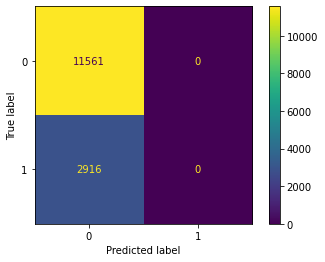

In [18]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_test, y_test)  # doctest: +SKIP
plt.show()

In [12]:
import pandas as pd
from sklearn import preprocessing

x = X_train.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X_train_scaled = pd.DataFrame(x_scaled)
X_train_scaled.columns = X_train.columns

In [13]:
import qgrid

qgrid.show_grid(X_train_scaled.head(100), grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [14]:
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'C': [1, 10], 'kernel': ['linear']},
  {'C': [1, 10], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]

clf = svm.SVC()

gcv = GridSearchCV(estimator=clf, param_grid=param_grid, verbose=1, cv=5)
gcv.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  9.1min finished


GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10], 'kernel': ['linear']},
                         {'C': [1, 10], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             verbose=1)

In [ ]:
print("Hello, world!")

In [23]:


train = pd.concat((X_train, y_train.rename('is_fraud')), axis=1)

train.head(100)

,amt,city_pop,age,distance,hour,day,month,year,category_food_dining,category_gas_transport,...,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M,is_fraud
31270,15.65,1252,83,80.980246,15,26,10,2019,0,0,...,1,0,0,0,0,0,0,0,0,0
30677,43.53,93193,25,50.912904,14,13,12,2020,1,0,...,0,0,0,0,0,0,0,0,1,0
21818,293.58,6629,58,92.386719,1,30,7,2020,0,0,...,0,0,1,0,0,0,0,0,0,0
11860,83.09,45303,50,84.984450,3,31,3,2020,0,1,...,0,0,0,0,0,0,0,0,0,0
25123,1.18,2135,16,120.327536,20,23,11,2020,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15526,9.76,4081,82,106.341304,8,25,11,2019,0,0,...,0,0,0,0,0,0,1,0,1,0
12431,264.67,3395,41,78.974152,12,20,3,2019,1,0,...,0,0,0,0,0,0,0,0,1,0
45524,303.77,1423,22,95.204397,2,14,5,2020,0,0,...,0,0,0,0,0,0,0,0,0,1
28218,7.28,139,66,32.276909,2,27,9,2019,0,0,...,0,0,0,0,0,0,1,0,0,0


In [26]:
import h2o
from h2o.automl import H2OAutoML

h2o.init(ip="localhost", port=54321)
h2o.connect()

train_hf = h2o.H2OFrame(train)
x = train_hf.columns
y = "is_fraud"
x.remove(y)

train_hf[y] = train_hf[y].asfactor()

# # Import a sample binary outcome train/test set into H2O
# train = h2o.import_file("https://s3.amazonaws.com/erin-data/higgs/higgs_train_10k.csv")
# test = h2o.import_file("https://s3.amazonaws.com/erin-data/higgs/higgs_test_5k.csv")

# # Identify predictors and response
# x = train.columns
# y = "response"
# x.remove(y)

# # For binary classification, response should be a factor
# train[y] = train[y].asfactor()
# test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=x, y=y, training_frame=train_hf)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,12 mins 33 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.3
H2O_cluster_version_age:,6 months and 8 days !!!
H2O_cluster_name:,perkinsc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.750 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Connecting to H2O server at http://localhost:54321 ... successful.


H2O_cluster_uptime:,12 mins 33 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.3
H2O_cluster_version_age:,6 months and 8 days !!!
H2O_cluster_name:,perkinsc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.750 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_4_AutoML_20201121_220947,0.998015,0.0456233,0.992773,0.0263911,0.113369,0.0128526
GBM_2_AutoML_20201121_220947,0.998006,0.0457453,0.992434,0.0280989,0.114074,0.0130128
GBM_3_AutoML_20201121_220947,0.997963,0.0457129,0.9926,0.029048,0.113821,0.0129553
GBM_1_AutoML_20201121_220947,0.997952,0.04589,0.992405,0.0241787,0.113497,0.0128816
StackedEnsemble_AllModels_AutoML_20201121_220947,0.997833,0.0551822,0.991995,0.0286387,0.117263,0.0137506
GBM_5_AutoML_20201121_220947,0.997731,0.0477142,0.991673,0.0293427,0.116806,0.0136436
XGBoost_3_AutoML_20201121_220947,0.997684,0.047934,0.991449,0.0287474,0.116429,0.0135557
XGBoost_grid__1_AutoML_20201121_220947_model_4,0.997683,0.0476462,0.991565,0.0314985,0.116238,0.0135114
StackedEnsemble_BestOfFamily_AutoML_20201121_220947,0.997599,0.0552864,0.991525,0.0301813,0.117431,0.0137901
GBM_grid__1_AutoML_20201121_220947_model_1,0.997516,0.0505207,0.990777,0.0290794,0.11944,0.014266


In [29]:
pip uninstall -y h2o

Found existing installation: h2o 3.30.1.3
Uninstalling h2o-3.30.1.3:
  Successfully uninstalled h2o-3.30.1.3
Note: you may need to restart the kernel to use updated packages.


In [31]:
pip install h2o==3.30.0.3

     |████████████████████████████████| 128.3 MB 382 kB/s eta 0:00:01     |███████████████████████         | 92.6 MB 354 kB/s eta 0:01:41
  Created wheel for h2o: filename=h2o-3.30.0.3-py2.py3-none-any.whl size=128358448 sha256=4af7a5e4327be41758e4397aa462025c71283cb16a2b26b4c2f1ab3d52dc57b6
  Stored in directory: /Users/perkinsc/Library/Caches/pip/wheels/36/1e/a3/daaee72516d0a3494ee07d04be41ed4b7cbcd9275e05a58b9e
Successfully built h2o
You should consider upgrading via the '/Users/perkinsc/Documents/Northeastern/EAI6000/eai6000_group5/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Commonly used modules
import numpy as np
import os
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import IPython
from six.moves import urllib

def build_model():
    model = keras.Sequential([
        Dense(20, activation=tf.nn.relu, input_shape=(X_train.shape[-1],)),
        Dense(1)
    ])

    model.compile(optimizer=tf.optimizers.Adam(), 
                  loss='mse',
                  metrics=['mae', 'mse'])
    return model

# this helps makes our output less verbose but still shows progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
history = model.fit(X_train, y_train, epochs=20, verbose=0, validation_split = 0.1,
                    callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

print(hist)

# show RMSE measure to compare to Kaggle leaderboard on https://www.kaggle.com/c/boston-housing/leaderboard
rmse_final = np.sqrt(float(hist['val_mse'].tail(1)))
print()
print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_final, 3)))


....................            loss         mae           mse      val_loss     val_mae  \
0   1.781288e+05   73.680473  1.781288e+05  5.896124e+03   28.998259   
1   4.953210e+05   95.510208  4.953210e+05  1.123063e+04   34.135975   
2   8.623320e+05   95.708160  8.623320e+05  1.586466e+02    8.708912   
3   1.078028e+04   19.746811  1.078028e+04  1.139970e+03   13.471470   
4   1.405579e+06  140.416351  1.405579e+06  1.436848e+05  134.948608   
5   3.144178e+03   16.461344  3.144178e+03  1.137954e+02    7.097110   
6   3.465385e+03   14.114442  3.465385e+03  4.055806e+03   32.697899   
7   4.388010e+04   32.020031  4.388010e+04  1.982125e+02    8.501140   
8   3.487015e+06  184.081360  3.487015e+06  5.151310e+02   14.647153   
9   2.314895e+02    9.261236  2.314895e+02  9.128627e+01    7.330310   
10  1.507795e+03   13.286129  1.507795e+03  1.152998e+02    8.369482   
11  9.929321e+05   90.239975  9.929321e+05  3.023900e+06  499.797485   
12  1.910243e+04   17.842958  1.910243e+04 

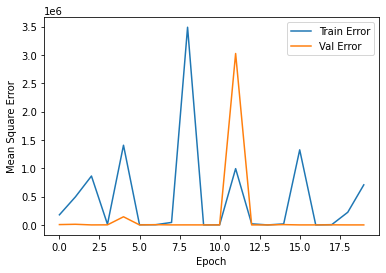

In [29]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.legend()

plot_history()

In [44]:
import keras
from keras.models import Sequential
from keras.layers import Dense

model = keras.Sequential([
        Dense(15, activation=tf.nn.relu, input_shape=(X_train.shape[-1],)),
        Dense(15, activation=tf.nn.relu),
        Dense(1, activation='sigmoid')
    ])

metrics = [
    keras.metrics.FalseNegatives(),
    keras.metrics.FalsePositives(),
    keras.metrics.TrueNegatives(),
    keras.metrics.TruePositives(),
    keras.metrics.Precision(),
    keras.metrics.Recall(),
    keras.metrics.BinaryAccuracy()
]

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = metrics)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min')
mcp_save = keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
callbacks = [early_stopping, mcp_save]

history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.25, callbacks=callbacks)


Epoch 1/100
792/792 [==============================] - 1s 2ms/step - loss: 141.6265 - false_negatives_3: 2520.0000 - false_positives_3: 1950.0000 - true_negatives_3: 18344.0000 - true_positives_3: 2519.0000 - precision_3: 0.5637 - recall_3: 0.4999 - binary_accuracy: 0.8236 - val_loss: 44.5957 - val_false_negatives_3: 1024.0000 - val_false_positives_3: 48.0000 - val_true_negatives_3: 6701.0000 - val_true_positives_3: 672.0000 - val_precision_3: 0.9333 - val_recall_3: 0.3962 - val_binary_accuracy: 0.8731
Epoch 2/100
792/792 [==============================] - 1s 1ms/step - loss: 14.5303 - false_negatives_3: 2080.0000 - false_positives_3: 1674.0000 - true_negatives_3: 18620.0000 - true_positives_3: 2959.0000 - precision_3: 0.6387 - recall_3: 0.5872 - binary_accuracy: 0.8518 - val_loss: 12.7153 - val_false_negatives_3: 688.0000 - val_false_positives_3: 326.0000 - val_true_negatives_3: 6423.0000 - val_true_positives_3: 1008.0000 - val_precision_3: 0.7556 - val_recall_3: 0.5943 - val_binary_a

792/792 [==============================] - 1s 1ms/step - loss: 0.3465 - false_negatives_3: 2446.0000 - false_positives_3: 446.0000 - true_negatives_3: 19848.0000 - true_positives_3: 2593.0000 - precision_3: 0.8532 - recall_3: 0.5146 - binary_accuracy: 0.8858 - val_loss: 0.3642 - val_false_negatives_3: 672.0000 - val_false_positives_3: 517.0000 - val_true_negatives_3: 6232.0000 - val_true_positives_3: 1024.0000 - val_precision_3: 0.6645 - val_recall_3: 0.6038 - val_binary_accuracy: 0.8592
Epoch 34/100
792/792 [==============================] - 1s 1ms/step - loss: 0.3224 - false_negatives_3: 2407.0000 - false_positives_3: 362.0000 - true_negatives_3: 19932.0000 - true_positives_3: 2632.0000 - precision_3: 0.8791 - recall_3: 0.5223 - binary_accuracy: 0.8907 - val_loss: 0.3125 - val_false_negatives_3: 804.0000 - val_false_positives_3: 85.0000 - val_true_negatives_3: 6664.0000 - val_true_positives_3: 892.0000 - val_precision_3: 0.9130 - val_recall_3: 0.5259 - val_binary_accuracy: 0.8947
Epo

792/792 [==============================] - 1s 1ms/step - loss: 0.3277 - false_negatives_3: 2269.0000 - false_positives_3: 296.0000 - true_negatives_3: 19998.0000 - true_positives_3: 2770.0000 - precision_3: 0.9035 - recall_3: 0.5497 - binary_accuracy: 0.8987 - val_loss: 0.2769 - val_false_negatives_3: 756.0000 - val_false_positives_3: 76.0000 - val_true_negatives_3: 6673.0000 - val_true_positives_3: 940.0000 - val_precision_3: 0.9252 - val_recall_3: 0.5542 - val_binary_accuracy: 0.9015
Epoch 66/100
792/792 [==============================] - 1s 1ms/step - loss: 0.2836 - false_negatives_3: 2172.0000 - false_positives_3: 263.0000 - true_negatives_3: 20031.0000 - true_positives_3: 2867.0000 - precision_3: 0.9160 - recall_3: 0.5690 - binary_accuracy: 0.9039 - val_loss: 0.2789 - val_false_negatives_3: 753.0000 - val_false_positives_3: 46.0000 - val_true_negatives_3: 6703.0000 - val_true_positives_3: 943.0000 - val_precision_3: 0.9535 - val_recall_3: 0.5560 - val_binary_accuracy: 0.9054
Epoch

792/792 [==============================] - 1s 959us/step - loss: 0.2240 - false_negatives_3: 1488.0000 - false_positives_3: 362.0000 - true_negatives_3: 19932.0000 - true_positives_3: 3551.0000 - precision_3: 0.9075 - recall_3: 0.7047 - binary_accuracy: 0.9270 - val_loss: 0.2089 - val_false_negatives_3: 517.0000 - val_false_positives_3: 59.0000 - val_true_negatives_3: 6690.0000 - val_true_positives_3: 1179.0000 - val_precision_3: 0.9523 - val_recall_3: 0.6952 - val_binary_accuracy: 0.9318
Epoch 98/100
792/792 [==============================] - 1s 1ms/step - loss: 0.2202 - false_negatives_3: 1444.0000 - false_positives_3: 376.0000 - true_negatives_3: 19918.0000 - true_positives_3: 3595.0000 - precision_3: 0.9053 - recall_3: 0.7134 - binary_accuracy: 0.9282 - val_loss: 0.2082 - val_false_negatives_3: 406.0000 - val_false_positives_3: 164.0000 - val_true_negatives_3: 6585.0000 - val_true_positives_3: 1290.0000 - val_precision_3: 0.8872 - val_recall_3: 0.7606 - val_binary_accuracy: 0.9325


In [45]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

import qgrid

qgrid.show_grid(hist.head(100), grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

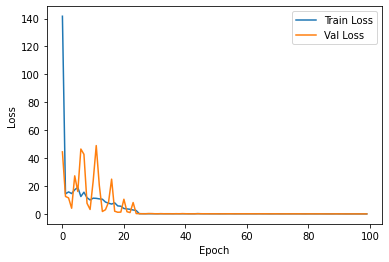

In [46]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Loss')
    plt.legend()

plot_history()

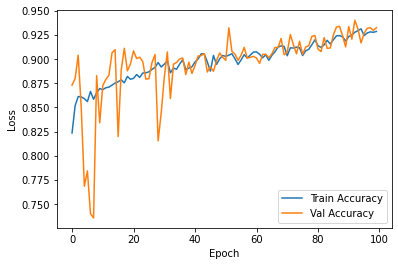

In [47]:
def plot_accuracy():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['binary_accuracy'], label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_binary_accuracy'], label = 'Val Accuracy')
    plt.legend()

plot_accuracy()

,amt,city_pop,age,distance,hour,day,month,year,category_food_dining,category_gas_transport,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
22537,9.42,571,53,45.508250,13,17,8,2019,0,0,...,0,0,1,0,0,0,0,0,0,1
6652,27.59,2206,33,110.774607,14,23,12,2020,0,0,...,0,0,0,0,0,0,0,0,0,0
21927,23.30,695,66,61.276575,19,6,10,2019,0,0,...,0,0,1,0,0,0,0,0,0,1
9392,60.78,276896,23,118.292577,8,29,8,2019,0,1,...,0,0,0,0,0,0,0,0,0,1
8969,26.43,2691,27,39.046047,12,11,12,2020,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38635,18.17,145,80,77.822083,23,4,1,2019,0,0,...,1,0,0,0,0,0,0,0,0,1
28390,44.84,642,74,42.804090,3,12,5,2020,0,1,...,0,0,0,0,0,0,0,0,0,0
16596,28.66,3096,45,65.037445,6,7,1,2019,0,0,...,0,0,0,0,0,0,0,0,0,1
47758,7.39,1360,36,4.712662,22,5,11,2020,0,0,...,0,0,0,0,1,0,0,0,0,1


In [54]:
y_pred = model.predict_classes(X_test)

from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[11381,   180],
       [  784,  2132]])

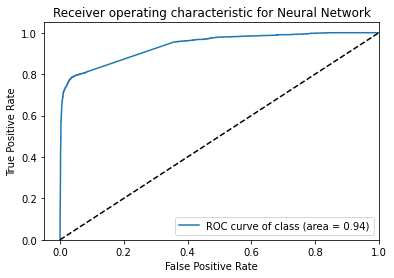

In [57]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier

n_classes = 1

y_score = model.predict_proba(X_test)


fpr = []
tpr = []
roc_auc = []
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"ROC curve of class (area = {roc_auc:.2f})")
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Neural Network')
plt.legend(loc="lower right")
plt.show()

In [58]:
pip install talos

     |████████████████████████████████| 53 kB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 5.4 MB 7.2 MB/s eta 0:00:01
     |████████████████████████████████| 23.3 MB 19.9 MB/s eta 0:00:01
     |████████████████████████████████| 2.6 MB 33.6 MB/s eta 0:00:01


  Created wheel for wrangle: filename=wrangle-0.6.7-py3-none-any.whl size=49894 sha256=4e03f9597364e8f2cb6846008a06233ecead8ec60a02f01130dcba2889ed6d72
  Stored in directory: /Users/perkinsc/Library/Caches/pip/wheels/1e/dc/3d/4698ee92cce8bd2c64eccfb7886540c53fb3cebe43d0ca1fb1
  Created wheel for kerasplotlib: filename=kerasplotlib-0.1.6-py3-none-any.whl size=3602 sha256=b2fc643b8e3f36ae3887b1a12b7bcd33ebd1e7910bbd1e6c51b42294a4e6f365
  Stored in directory: /Users/perkinsc/Library/Caches/pip/wheels/49/f1/a2/c1a52cd15ac3769ed9f4e8c7a22b575f82197a49123b29630b
  Created wheel for chances: filename=chances-0.1.9-py3-none-any.whl size=41608 sha256=f9bd2b4a5d019ffc18b4f30c967ec22a42ca4d62bb6d0120147a1b37c57710d4
  Stored in directory: /Users/perkinsc/Library/Caches/pip/wheels/bc/47/dc/208d4038848287f804b6ededf43632ba7dbea530fdb3a069e4
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=c2872df0214abe8dfd636f5a5fb54c2aed044c34ebbc831efc5b1772cfbcc323
  Store

  scipy/integrate/odepack/zvode.f:2665:72:
  
   2665 |  110    EL(J) = ZERO
        |                                                                        1
  scipy/integrate/odepack/vode.f:2700:72:
  
   2700 |  310    EL(J) = ZERO
        |                                                                        1
  scipy/integrate/odepack/zvode.f:2675:72:
  
   2675 |  120      EL(I) = EL(I)*XI + EL(I-1)
        |                                                                        1
  scipy/integrate/odepack/zvode.f:2679:72:
  
   2679 |  140    EL(J+1) = REAL(NQ)*EL(J)/REAL(J)
        |                                                                        1
  scipy/integrate/odepack/vode.f:2718:72:
  
   2718 |  320      EL(I) = EL(I)*XIOLD + EL(I-1)
        |                                                                        1
  scipy/integrate/odepack/zvode.f:2683:72:
  
   2683 |  160      YH(I,J) = YH(I,J) - YH(I,L)*EL(J)
        |                                      

  ERROR: Command errored out with exit status 1:
   command: /Users/perkinsc/Documents/Northeastern/EAI6000/eai6000_group5/env/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/9_/wb3m9t0j1txbpr5znb6qb0595bjcfj/T/pip-install-fs33pr5g/scipy/setup.py'"'"'; __file__='"'"'/private/var/folders/9_/wb3m9t0j1txbpr5znb6qb0595bjcfj/T/pip-install-fs33pr5g/scipy/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' clean --all
       cwd: /private/var/folders/9_/wb3m9t0j1txbpr5znb6qb0595bjcfj/T/pip-install-fs33pr5g/scipy
  Complete output (11 lines):
  /private/var/folders/9_/wb3m9t0j1txbpr5znb6qb0595bjcfj/T/pip-install-fs33pr5g/scipy/setup.py:114: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
    import imp
  
  `setup.py clean` is not supported, use one of t

You should consider upgrading via the '/Users/perkinsc/Documents/Northeastern/EAI6000/eai6000_group5/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [39]:
import talos
import keras
from keras.models import Sequential
from keras.layers import Dense


p = {'activation':['relu', 'elu'],
     'optimizer': ['Nadam', 'Adam'],
     'losses': ['binary_crossentropy'],
     'batch_size': [20,30,40],
     'epochs': [100,200]}

def fraud_model(x_train, y_train, x_val, y_val, params):
    metrics = [
        keras.metrics.FalseNegatives(),
        keras.metrics.FalsePositives(),
        keras.metrics.TrueNegatives(),
        keras.metrics.TruePositives(),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
        keras.metrics.BinaryAccuracy()
    ]

    model = Sequential()
    model.add(Dense(15, activation=params['activation'], input_shape=(X_train.shape[-1],)))
    model.add(Dense(15, activation=params['activation']))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=params['optimizer'], loss=params['losses'], metrics=metrics)

    out = model.fit(x_train, y_train,
                     batch_size=params['batch_size'],
                     epochs=params['epochs'],
                     validation_split=0.2,
                     verbose=0)

    return out, model

scan_object = talos.Scan(X_train.to_numpy(), y_train.to_numpy(), model=fraud_model, params=p, experiment_name='fraud', fraction_limit=0.1)

100%|██████████| 2/2 [06:14<00:00, 187.29s/it]


In [33]:
import talos
from keras.models import Sequential
from keras.layers import Dense

x, y = talos.templates.datasets.iris()

p = {'activation':['relu', 'elu'],
     'optimizer': ['Nadam', 'Adam'],
     'losses': ['categorical_crossentropy'],
     'batch_size': [20,30,40],
     'epochs': [10,20]}

def iris_model(x_train, y_train, x_val, y_val, params):
    model = Sequential()
    model.add(Dense(32, input_dim=4, activation=params['activation']))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=params['optimizer'], loss=params['losses'], metrics=metrics)

    out = model.fit(x_train, y_train,
                     batch_size=params['batch_size'],
                     epochs=params['epochs'],
                     validation_data=(x_val, y_val),
                     verbose=0)

    return out, model

scan_object = talos.Scan(x, y, model=iris_model, params=p, experiment_name='iris', fraction_limit=0.1)




  0%|          | 0/2 [05:41<?, ?it/s]


 50%|█████     | 1/2 [00:02<00:02,  2.17s/it]

100%|██████████| 2/2 [00:04<00:00,  2.03s/it]


In [40]:
y_pred = scan_object.best_model(metric='binary_accuracy', asc=False).predict_classes(X_test)

from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[11427,   134],
       [  870,  2046]])

In [25]:
y_test.to_numpy()

array([0, 0, 0, ..., 0, 1, 0])

Instructions for updating:
Please use `model.predict()` instead.


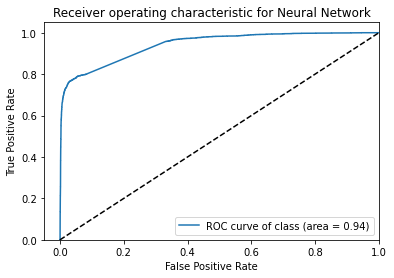

In [41]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier

n_classes = 1

y_score = scan_object.best_model(metric='binary_accuracy', asc=False).predict_proba(X_test)


fpr = []
tpr = []
roc_auc = []
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"ROC curve of class (area = {roc_auc:.2f})")
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Neural Network')
plt.legend(loc="lower right")
plt.show()